In [1]:
from fastai.vision.all import *
from fastai.vision.data import *
from pathlib import WindowsPath, Path
from ipywidgets import *
from numba import njit
from colorama import Fore
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# path = Path('rocks')
def getData(items:'list|tuple', path:'WindowsPath|Path', key:str) -> get_image_files:
    if not path.exists():
        path.mkdir()
        for item in items:
            item_dest = (path/item)
            results = search_images_bing(key, item)
            download_images(item_dest, urls=results.attrgot('content_url'))
    
    #get image file names       
    fname = get_image_files(path)
    
    fname = verify_images(fname).map(Path.unlink())
    
    return fname

In [3]:
# getData(['igneous rock', 'sedimentary rock', 'metarmorphic rock'], Path('rock'), '***')

In [4]:
# @njit(cache=True)
def dataBlock(bs:'int', size:'int', path:'WindowsPath | Path', dir_:'str') -> 'DataLoaders':
    '''
    args::
        bs: batch_size
        size: image resize option during item or transformation 
        path: WindowsPath or path object that point to the dir 
        dir_: image files directory of folder
    returns a dataloader object that will serve as input to the model
    '''
    
    assert bs <= 5, 'Batch Size must be less than or equal to 5'
    
    datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_items=get_image_files,
                         get_y=parent_label,#using_attr(RegexLabeller(r'(\w+).?\d+.?jpg$'), 'name'),
                         item_tfms=Resize(size=size, method=RandomResizedCrop(size, min_scale=0.3)), 
                          #Normalize.from_stats(mean=0, std=1)],
                         splitter=RandomSplitter(valid_pct=0.3, seed=20),
                         batch_tfms=[*aug_transforms(size=224, do_flip=True, flip_vert=True,
                                                   mult=0.2, min_scale=0.75), Normalize()]                    
                 )
    dataloader = datablock.dataloaders((path/dir_), bs=bs)
    
    return dataloader

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


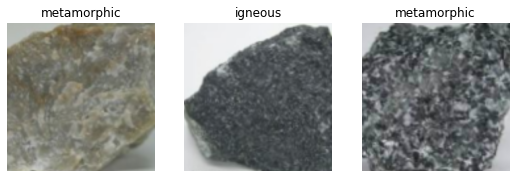

In [5]:
path = Path(r'C:\Users\USER\Documents\Flask project\rock-identifier')
     
dataloader = dataBlock(3, 128, path=path, dir_='rock')

dataloader.show_batch()    

# model building

learner = Learner(dataloader, xresnet18(pretrained=False),
                      metrics=[error_rate, accuracy], loss_func=LabelSmoothingCrossEntropyFlat(), cbs=MixUp)


In [6]:
#model training
learner.fit_one_cycle(n_epoch=1, lr_max=3e-3)

learner.dataloader = dataBlock(5, 224, path=path, dir_='rock')#progressiive resizing

learner.fine_tune(epochs=2, base_lr=3e-3)#slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.954016,6.414468,1.000000,0.000000,00:09


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.832093,4.480012,0.500000,0.500000,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.744008,3.806832,0.500000,0.500000,00:07
1,4.158751,2.694895,0.000000,1.000000,00:07


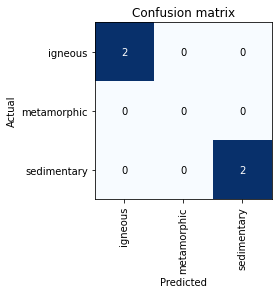

In [7]:
#model metrics
interp = ClassificationInterpretation.from_learner(learner)

interp.plot_confusion_matrix()

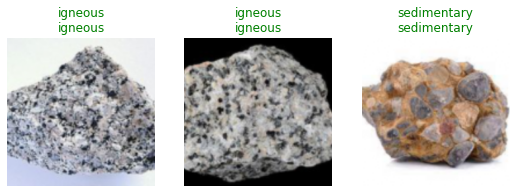

In [8]:
learner.show_results()

In [9]:
#save model

learner.export('rock-identifier.pkl')

inference_learner = load_learner('rock-identifier.pkl')


# Web Deployment

In [28]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
label_pred = widgets.Label()
output = widgets.Output()
output.clear_output()

def on_click_predict(change):
    img = PILImage.create(btn_upload.data[-1]) #grabs the image
    with output: 
        display(img.to_thumb(224, 224))
    pred, pred_idx, probs = inference_learner.predict(img) 
    label_pred.value = f'This is a {pred.upper()} rock; Probability: {1-probs[pred_idx]:.4f}'

btn_run.on_click(on_click_predict)

VBox([widgets.Label('Upload rock photo.'), btn_upload, btn_run, output, label_pred])

In [ ]:
https://mybinder.org/v2/gh/mayor-of-geology/rock-classifier/HEAD?urlpath=%2Fvoila%2Frender%2Fapp.ipynb